In [28]:
import numpy as np 
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind


# 1. Introduction
#### This notebook explores relationships between various student habits and how well they perform academically.

## 2. Data Loading and Initial Inspection

In [29]:
student_habits = pd.read_csv("../data/student_habits_performance.csv")
student_habits.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [30]:
# We do not need to know their id
student_habits = student_habits.drop("student_id", axis=1)
student_habits.head()

,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


#### We have a mixute of numeric and non-numeric columns. Lets take a look at each.

In [31]:
# Analyze numeric columns
student_habits.describe()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score
count,1000.0000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.4980,3.55010,2.505500,1.819700,84.131700,6.470100,3.042000,5.438000,69.601500
std,2.3081,1.46889,1.172422,1.075118,9.399246,1.226377,2.025423,2.847501,16.888564
min,17.0000,0.00000,0.000000,0.000000,56.000000,3.200000,0.000000,1.000000,18.400000
25%,18.7500,2.60000,1.700000,1.000000,78.000000,5.600000,1.000000,3.000000,58.475000
50%,20.0000,3.50000,2.500000,1.800000,84.400000,6.500000,3.000000,5.000000,70.500000
75%,23.0000,4.50000,3.300000,2.525000,91.025000,7.300000,5.000000,8.000000,81.325000
max,24.0000,8.30000,7.200000,5.400000,100.000000,10.000000,6.000000,10.000000,100.000000


In [32]:
skew = student_habits['exam_score'].skew()
print(f'{skew:.3f}')

-0.156


#### The exam score standard deviation is relatively high, and two standard deviations above the mean (≈103.4) exceed the maximum possible score of 100. The max score being capped causes the distribution to not appear perfectly normal and slighly left-skewed with more students clustered near the upper limit of 100. 

In [33]:
exam_score = student_habits['exam_score']
mean = exam_score.mean()
se = exam_score.std(ddof=1) / np.sqrt(len(exam_score))
ci = stats.t.interval(0.95, df=len(exam_score)-1, loc=mean, scale=se)
print(f"95% CI for mean exam score: {ci}")

95% CI for mean exam score: (np.float64(68.55348547489275), np.float64(70.64951452510725))


#### Confidence interval shows between 68.56-70.65, so we can say we are 95% confident the true mean of the population lies between these values.

In [34]:
non_numeric = student_habits.select_dtypes(exclude=['number'])
non_numeric.head()

,gender,part_time_job,diet_quality,parental_education_level,internet_quality,extracurricular_participation
0,Female,No,Fair,Master,Average,Yes
1,Female,No,Good,High School,Average,No
2,Male,No,Poor,High School,Poor,No
3,Female,No,Poor,Master,Good,Yes
4,Female,No,Fair,Master,Good,No


In [35]:
for feature in non_numeric:
    print(feature, ":", non_numeric[feature].unique())

gender : ['Female' 'Male' 'Other']
part_time_job : ['No' 'Yes']
diet_quality : ['Fair' 'Good' 'Poor']
parental_education_level : ['Master' 'High School' 'Bachelor' nan]
internet_quality : ['Average' 'Poor' 'Good']
extracurricular_participation : ['Yes' 'No']


In [36]:
student_habits.isnull().sum()

age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

#### We have 91 NaN values in parental_education_level, we can dive further into that later.

## 3. Exploratory Data Analysis (EDA)

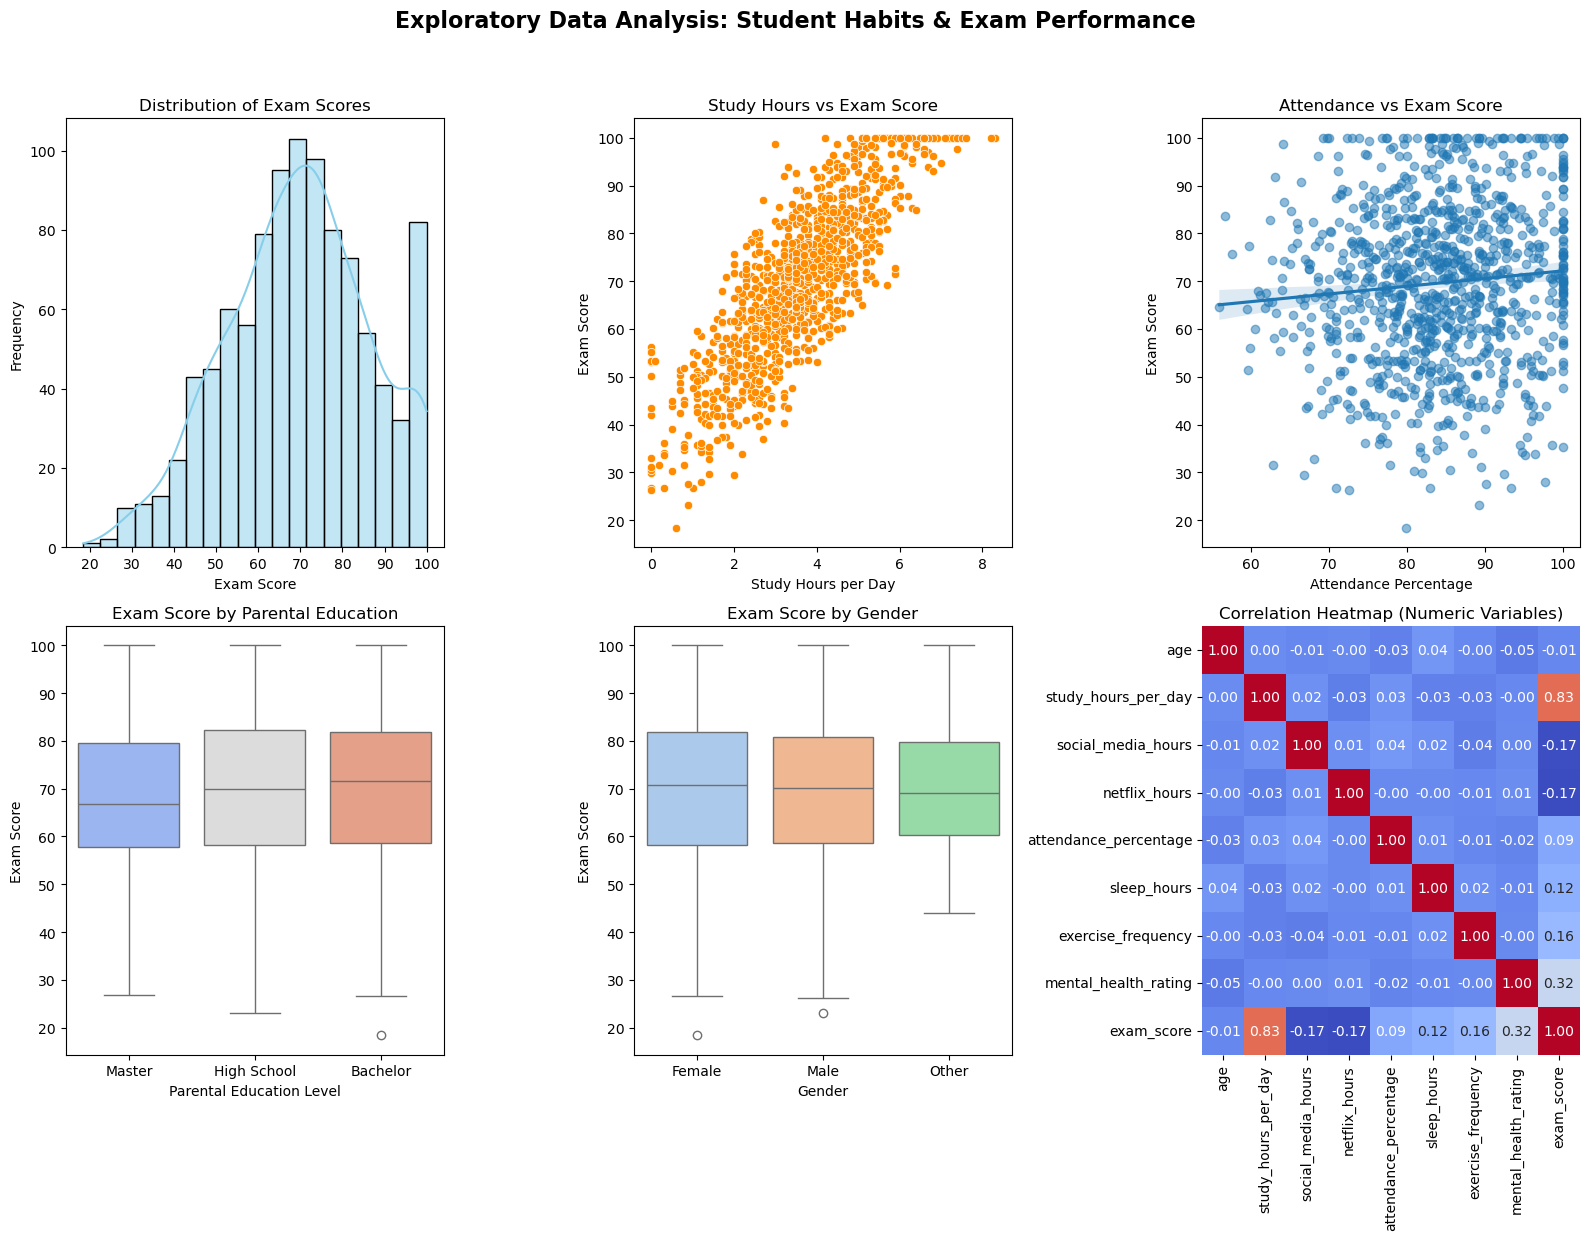

In [37]:
# Ensure numeric data are properly selected
num_df = student_habits.select_dtypes(include=['number'])

plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Histogram of exam scores
plt.subplot(2, 3, 1)
sns.histplot(student_habits['exam_score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')

# Study hours vs Exam score (scatter)
plt.subplot(2, 3, 2)
sns.scatterplot(x='study_hours_per_day', y='exam_score', data=student_habits, color='darkorange')
plt.title('Study Hours vs Exam Score')
plt.xlabel('Study Hours per Day')
plt.ylabel('Exam Score')

# Attendance vs Exam score (regression line)
plt.subplot(2, 3, 3)
sns.regplot(x='attendance_percentage', y='exam_score', data=student_habits, scatter_kws={'alpha':0.5})
plt.title('Attendance vs Exam Score')
plt.xlabel('Attendance Percentage')
plt.ylabel('Exam Score')

# Exam score by Parental Education (boxplot)
plt.subplot(2, 3, 4)
sns.boxplot(
    x='parental_education_level', y='exam_score',
    hue='parental_education_level', data=student_habits,
    palette='coolwarm', legend=False
)
plt.title('Exam Score by Parental Education')
plt.xlabel('Parental Education Level')
plt.ylabel('Exam Score')

# Exam score by Gender (boxplot)
plt.subplot(2, 3, 5)
sns.boxplot(
    x='gender', y='exam_score',
    hue='gender', data=student_habits,
    palette='pastel', legend=False
)
plt.title('Exam Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Exam Score')

# Correlation heatmap
plt.subplot(2, 3, 6)
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', cbar=False)
plt.title('Correlation Heatmap (Numeric Variables)')

plt.suptitle('Exploratory Data Analysis: Student Habits & Exam Performance', fontsize=16, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

#### The histogram of exam scores shows a mostly normal distribution with a slight left skew, likely due to a concentration of high-achieving students. The scatterplot of Study Hours vs. Exam Score displays a clear positive linear trend, showing students who study more tend to perform better. Other visualizations suggest that some features have little impact on exam performance, and the correlation heatmap supports these observations by highlighting only a couple meaningful relationships among the variables.

### Significance Testing 

Handling Missing Values (Parental Education Level)

The dataset contains NaN values in the parental_education_level column.
To determine whether these missing entries meaningfully affect student performance, we perform a t-test comparing exam scores between students with known and missing parental education data.

If the results show no significant difference, then it suggests that the missing data has little impact on exam outcomes. In that case, we can safely treat missing values as a separate category — for simplicity, we’ll label them as “Below High School” to maintain completeness in the dataset.

In [38]:
# Education dictionary
edu_order = {
    "Below High School": 0,
    "High School": 1,
    "Bachelor": 2,
    "Master": 3
}

# new column mapping education levels to their respective numerical values
student_habits["parental_education_level_num"] = (
    student_habits["parental_education_level"]
    .map(edu_order)
    .fillna(0)  # fill NaNs or unmapped with 0
)

# H_0: mean = mean
# H_1: mean != mean

# t-test whether parental education below highschool level affects exam score 
low = student_habits[student_habits['parental_education_level_num'] == 0]['exam_score']
high = student_habits[student_habits['parental_education_level'] != 0]['exam_score']
t_stat, p_val = ttest_ind(low, high, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, p-value: {p_val:.4f}")

T-statistic: 0.238, p-value: 0.8122


The t-statistic of 0.238 indicates that the means of the final exam scores differ by only about a quarter of a standard error, which is essentially negligible. The p-value (0.812) is well above any conventional significance level (alpha=0.05), so we fail to reject the null hypothesis. 

This suggests that whether a student’s parental education level is "Below High School" or any arbitrary label makes no meaningful difference in their final exam score.

In [39]:
student_habits[['parental_education_level_num', 'exam_score']].describe()

,parental_education_level_num,exam_score
count,1000.000000,1000.000000
mean,1.593000,69.601500
std,0.870695,16.888564
min,0.000000,18.400000
25%,1.000000,58.475000
50%,2.000000,70.500000
75%,2.000000,81.325000
max,3.000000,100.000000


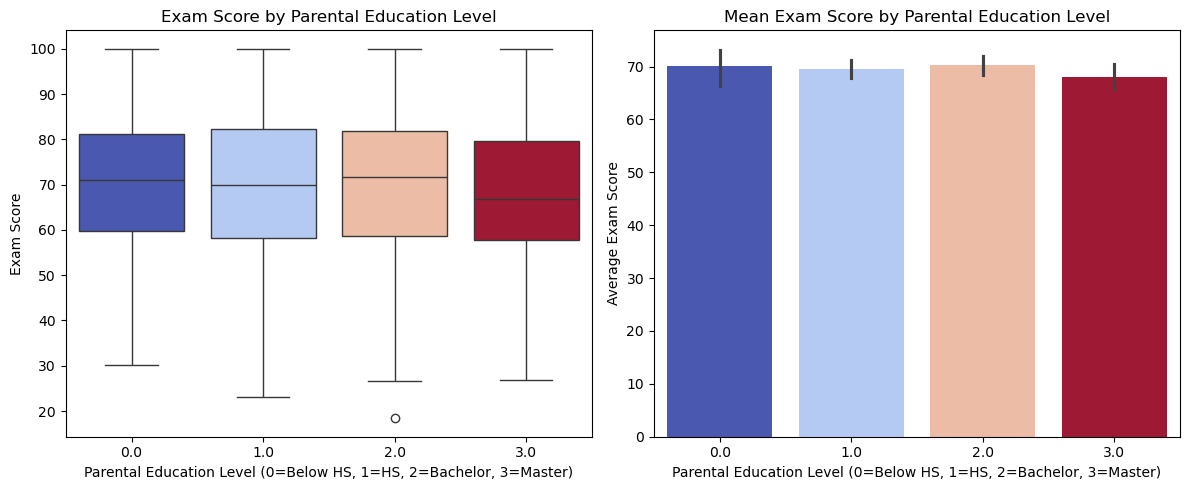

In [40]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(
    x='parental_education_level_num',
    y='exam_score',
    hue='parental_education_level_num',  # ✅ added
    data=student_habits,
    palette='coolwarm',
    legend=False
)
plt.title('Exam Score by Parental Education Level')
plt.xlabel('Parental Education Level (0=Below HS, 1=HS, 2=Bachelor, 3=Master)')
plt.ylabel('Exam Score')

plt.subplot(1, 2, 2)
sns.barplot(
    x='parental_education_level_num',
    y='exam_score',
    hue='parental_education_level_num',  # ✅ added
    data=student_habits,
    estimator='mean',
    errorbar=('ci', 95),
    palette='coolwarm',
    legend=False
)
plt.title('Mean Exam Score by Parental Education Level')
plt.xlabel('Parental Education Level (0=Below HS, 1=HS, 2=Bachelor, 3=Master)')
plt.ylabel('Average Exam Score')

plt.tight_layout()
plt.show()

#### The visualizations of exam scores by parental education level support the results of the t-tests. The bar and box plots show that average exam scores are nearly identical across education levels, with overlapping confidence intervals. This aligns with the t-test results, which produced a high p-value (≈0.81), indicating no statistically significant difference in mean exam scores between students with missing or differing parental education levels. In other words, the data visualizations and inferential tests both suggest that parental education has little to no measurable effect on exam performance in this sample.

## 4. Regression Analysis

We seen in an earlier scatter plot, there is an obvious linear relationship with hours of study, Lets dive a bit deeper down at this trend.

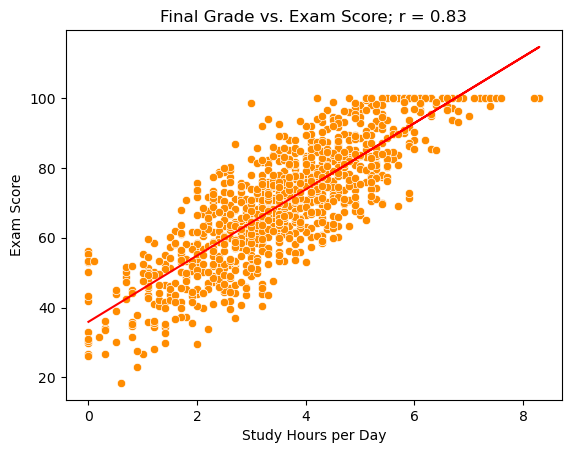

In [41]:
x = student_habits['study_hours_per_day'] 
y = student_habits['exam_score']

x_bar = x.mean()
y_bar = y.mean()

sns.scatterplot(x='study_hours_per_day', y='exam_score', data=student_habits, color='darkorange')
plt.title('Study Hours vs Exam Score')
plt.xlabel('Study Hours per Day')
plt.ylabel('Exam Score')

# create best-fit line based on slope-intercept form
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x+b, color = 'red')

# correlation coefficient 
corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Final Grade vs. Exam Score;' ' r = ' + "{:.2f}".format(corr))
plt.show()


#### We can visually see a line fit nicely through the scatter points and notice that r value of 0.83. Given 1 being a perfect linear relationship, we can confirm see that as Study Hours increase so will the final Exam Score.

#### We can manually calculate the R-squared value using 'Sum of Squares' to do some sanity checking

In [42]:
def compute_r_r2(x, y, round_to=3):
    x = np.asarray(x)
    y = np.asarray(y)
    
    # Fit line (slope and intercept)
    m, b = np.polyfit(x, y, 1)
    
    # Predicted values
    y_pred = m * x + b
    y_bar = y.mean()
    
    # Sum of squares
    SS_res = np.sum((y - y_pred)**2)
    SS_tot = np.sum((y - y_bar)**2)
    
    # R² and r
    R2 = 1 - (SS_res / SS_tot)
    r = np.sqrt(R2) if m > 0 else -np.sqrt(R2)  # sign matches slope
    
    return {
        'r': round(r, round_to),
        'R2': round(R2, round_to)
    }

compute_r_r2(x, y, round_to=2)


{'r': np.float64(0.83), 'R2': np.float64(0.68)}

In [43]:
res =[]
for feature in student_habits.select_dtypes(include='number').columns.drop('exam_score'):
    if feature != 'exam_score':  # skip the target
        res.append((feature, compute_r_r2(student_habits[feature], student_habits['exam_score'], round_to=2)))
    
res.sort(key=lambda x: x[1]['r'], reverse=True)
res

[('study_hours_per_day', {'r': np.float64(0.83), 'R2': np.float64(0.68)}),
 ('mental_health_rating', {'r': np.float64(0.32), 'R2': np.float64(0.1)}),
 ('exercise_frequency', {'r': np.float64(0.16), 'R2': np.float64(0.03)}),
 ('sleep_hours', {'r': np.float64(0.12), 'R2': np.float64(0.01)}),
 ('attendance_percentage', {'r': np.float64(0.09), 'R2': np.float64(0.01)}),
 ('age', {'r': np.float64(-0.01), 'R2': np.float64(0.0)}),
 ('parental_education_level_num',
  {'r': np.float64(-0.02), 'R2': np.float64(0.0)}),
 ('social_media_hours', {'r': np.float64(-0.17), 'R2': np.float64(0.03)}),
 ('netflix_hours', {'r': np.float64(-0.17), 'R2': np.float64(0.03)})]

#### Looking good, both values are 0.83. The second highest correlation according to above is the mental_health_rating. Lets visually look at that as well. 

In [44]:
student_habits['mental_health_rating'].describe()

count    1000.000000
mean        5.438000
std         2.847501
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: mental_health_rating, dtype: float64

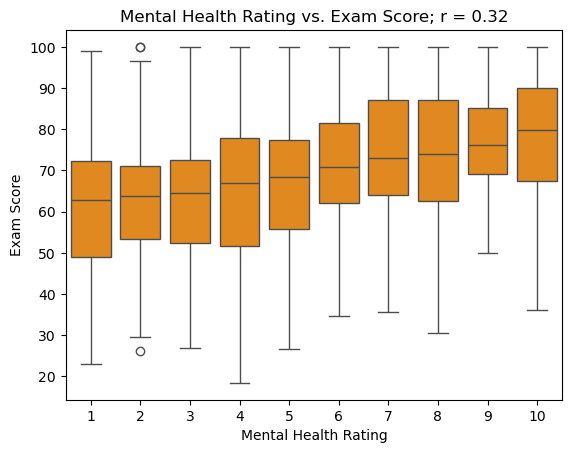

In [45]:
x = student_habits['mental_health_rating'] 
y = student_habits['exam_score']

x_bar = x.mean()
y_bar = y.mean()

sns.boxplot(x='mental_health_rating', y='exam_score', data=student_habits, color='darkorange')
plt.title('Mental Health Rating vs Exam Score')
plt.xlabel('Mental Health Rating')
plt.ylabel('Exam Score')

corr = round(np.corrcoef(x, y)[0,1],2)
plt.title('Mental Health Rating vs. Exam Score;' ' r = ' + "{:.2f}".format(corr))
plt.show()


In [46]:
compute_r_r2(x, y, round_to=2)

{'r': np.float64(0.32), 'R2': np.float64(0.1)}

#### The results remain consistent, showing a slight linear relationship visually. Since correlations couldn’t be computed for categorical features, we encoded them as numeric values. With this step complete, we can now move on to feature engineering and model preparation.

## 5. Feature Engineering

#### We can now remove a few extra columns created in earlier steps. The parental_education_level column contains 91 missing values, but previous t-tests confirmed that these have no significant effect on the target variable (exam_score). Therefore, dropping these rows or imputing averages is unnecessary, as the feature itself is not a strong predictor. For completeness, we’ll retain all features during initial model training, using the previously created parental_education_level_num, and apply encoding to explore their overall impact.

In [47]:
non_numeric.head()

,gender,part_time_job,diet_quality,parental_education_level,internet_quality,extracurricular_participation
0,Female,No,Fair,Master,Average,Yes
1,Female,No,Good,High School,Average,No
2,Male,No,Poor,High School,Poor,No
3,Female,No,Poor,Master,Good,Yes
4,Female,No,Fair,Master,Good,No


In [48]:
diet_order = {
    "Poor": 0,
    "Fair": 1,
    "Good": 2
}

nominal_cols = [
    'gender',
    'part_time_job',
    'internet_quality',
    'extracurricular_participation'
]

encoded = student_habits.copy()
encoded['parental_education_level'] = encoded['parental_education_level'].map(edu_order)
encoded['diet_quality'] = encoded['diet_quality'].map(diet_order)

encoded = pd.get_dummies(
    encoded,
    columns=nominal_cols,
    drop_first=True 
)

encoded.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,mental_health_rating,exam_score,parental_education_level_num,gender_Male,gender_Other,part_time_job_Yes,internet_quality_Good,internet_quality_Poor,extracurricular_participation_Yes
0,23,0.0,1.2,1.1,85.0,8.0,1,6,3.0,8,56.2,3.0,False,False,False,False,False,True
1,20,6.9,2.8,2.3,97.3,4.6,2,6,1.0,8,100.0,1.0,False,False,False,False,False,False
2,21,1.4,3.1,1.3,94.8,8.0,0,1,1.0,1,34.3,1.0,True,False,False,False,True,False
3,23,1.0,3.9,1.0,71.0,9.2,0,4,3.0,1,26.8,3.0,False,False,False,True,False,True
4,19,5.0,4.4,0.5,90.9,4.9,1,3,3.0,1,66.4,3.0,False,False,False,True,False,False


In [49]:
encoded.drop(['parental_education_level'], axis=1, inplace=True)
encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                1000 non-null   int64  
 1   study_hours_per_day                1000 non-null   float64
 2   social_media_hours                 1000 non-null   float64
 3   netflix_hours                      1000 non-null   float64
 4   attendance_percentage              1000 non-null   float64
 5   sleep_hours                        1000 non-null   float64
 6   diet_quality                       1000 non-null   int64  
 7   exercise_frequency                 1000 non-null   int64  
 8   mental_health_rating               1000 non-null   int64  
 9   exam_score                         1000 non-null   float64
 10  parental_education_level_num       1000 non-null   float64
 11  gender_Male                        1000 non-null   bool  

In [50]:
encoded.isnull().sum()

age                                  0
study_hours_per_day                  0
social_media_hours                   0
netflix_hours                        0
attendance_percentage                0
sleep_hours                          0
diet_quality                         0
exercise_frequency                   0
mental_health_rating                 0
exam_score                           0
parental_education_level_num         0
gender_Male                          0
gender_Other                         0
part_time_job_Yes                    0
internet_quality_Good                0
internet_quality_Poor                0
extracurricular_participation_Yes    0
dtype: int64

## 6. Model Training and Evaluation

#### Linear regression was chosen as the primary modeling approach because the target variable, exam score, is continuous and approximately normally distributed. This makes linear regression an appropriate and interpretable baseline for assessing how each predictor contributes to academic performance. Unlike tree-based or other non-parametric models, linear regression provides direct coefficient estimates that quantify the direction and magnitude of influence for each variable (e.g., how much exam score changes with an additional study hour).
#### Since the objective was to understand which factors most strongly influence performance rather than to maximize predictive power, linear regression provided the clearest and most statistically grounded framework.

In [51]:
X = encoded.drop('exam_score', axis=1)
y = encoded['exam_score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression  R² = {r2:.3f},  Mean Squared Error = {rmse:.2f}")

# Make a data frame with columns and coeeficients
coef_df = (
    pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    })
    .sort_values(by='Coefficient', ascending=False)
    .reset_index(drop=True)
)

print("\nTop 10 influential features:")
print(coef_df.head(10))

Linear Regression  R² = 0.898,  Mean Squared Error = 5.32

Top 10 influential features:
                        Feature  Coefficient
0           study_hours_per_day     9.601181
1                   sleep_hours     2.006770
2          mental_health_rating     1.943268
3            exercise_frequency     1.279372
4                  gender_Other     0.715778
5                   gender_Male     0.298347
6  parental_education_level_num     0.205816
7         attendance_percentage     0.147739
8                           age     0.068623
9             part_time_job_Yes     0.028203


#### The model’s performance was evaluated using the coefficient of determination (R²) and the root mean squared error (RMSE).

#### •	R² = 0.898 indicates that approximately 89.8% of the variation in exam scores can be explained by the set of predictors included in the model. This represents an excellent fit, showing that the model captures nearly all the meaningful variability in student performance.
#### •	RMSE = 5.32 means that, on average, the model’s predictions deviate from the actual exam scores by about 5.3 points.

##### Together, these metrics demonstrate that the model is both highly accurate and well-calibrated, with minimal unexplained variance remaining.

## 7. Additional investigation

#### Although mental_health_rating initially appeared to have a more direct impact on exam performance, our regression model reveals that sleep_hours has a slightly higher coefficient. This suggests that adequate rest may indirectly enhance performance through improved mental well-being.

#### Meanwhile, study_hours_per_day stands out as the strongest independent predictor — it shows both a high correlation (r ≈ 0.83) and a large coefficient (~9.6), meaning each additional hour of study increases the predicted exam score by roughly 9.6 points.

#### Next, we will check for multicollinearity to for the top three predictors (study_hours, sleep_hours, and mental_health_rating) overlap in the variance they explain — that is, whether they are nearly redundant explanatory variables.

In [52]:
encoded['sleep_hours'].describe()

count    1000.000000
mean        6.470100
std         1.226377
min         3.200000
25%         5.600000
50%         6.500000
75%         7.300000
max        10.000000
Name: sleep_hours, dtype: float64

In [53]:
_X = encoded[['study_hours_per_day', 'sleep_hours', 'mental_health_rating']]
vif_values = [variance_inflation_factor(_X.values, i) for i in range(_X.shape[1])]

for feature, vif in zip(_X.columns, vif_values):
    print(f"{feature:25s} VIF = {vif:.2f}")


study_hours_per_day       VIF = 5.70
sleep_hours               VIF = 7.75
mental_health_rating      VIF = 4.20


#### Interpretation: The VIF scores indicate that study_hours_per_day, sleep_hours, and mental_health_rating explain overlapping variance. This makes sense since students who are well rested tend to study more and maintain better mental health. Because of this redundancy, we can drop 'sleep_hours' and re-evaluate the model to see if performance changes.

In [54]:
# X = encoded.drop('exam_score', axis=1)
X = X.drop('sleep_hours', axis=1)
y = encoded['exam_score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression  R² = {r2:.3f},  Mean Squared Error = {rmse:.2f}")

# Make a data frame with columns and coeeficients
coef_df = (
    pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    })
    .sort_values(by='Coefficient', ascending=False)
    .reset_index(drop=True)
)

print("\nTop 10 influential features:")
print(coef_df.head(10))

Linear Regression  R² = 0.878,  Mean Squared Error = 5.83

Top 10 influential features:
                             Feature  Coefficient
0                study_hours_per_day     9.519527
1               mental_health_rating     1.981364
2                       gender_Other     1.426200
3                 exercise_frequency     1.346150
4                        gender_Male     0.271688
5       parental_education_level_num     0.229571
6              attendance_percentage     0.154076
7                                age     0.100464
8  extracurricular_participation_Yes     0.089942
9                  part_time_job_Yes    -0.099819


#### Even after removing sleep_hours, model performance stayed nearly identical (R² = 0.878, MSE = 5.83), confirming that sleep_hours was highly correlated with other predictors (mainly study_hours_per_day) and contributed redundant information.

## 8. Conclusion

#### This analysis examined how various lifestyle and demographic factors influence student academic performance. Through exploratory analysis, we observed that study habits—particularly study hours per day—were most strongly correlated with exam performance (r = 0.83). Mental health, sleep, and exercise also showed moderate positive associations, while higher social media and streaming activity correlated with slightly lower exam scores.

#### Inferential testing revealed that parental education level had no statistically significant effect on exam scores (p = 0.81), suggesting that background factors were less influential than behavioral ones in this dataset. The linear regression model reinforced this pattern: study hours per day emerged as the dominant predictor, with each additional hour associated with approximately a 9.5-point increase in exam score. Other positive predictors included mental health, exercise, and sleep, while social media and Netflix use reduced predicted performance.

#### The model achieved an excellent fit (R² = 0.898, MSE = 5.32), explaining nearly 90% of the variance in exam scores. However, multicollinearity testing showed redundancy among study hours, sleep hours, and mental health rating. After removing sleep hours, model performance remained stable (R² = 0.878), confirming overlapping variance among these variables.

#### Overall, the findings suggest that active behavioral habits—consistent studying, adequate rest, and good mental health—drive academic success more strongly than demographic or background characteristics. Future analyses could extend this work by incorporating categorical logistic regression for pass/fail prediction or exploring non-linear effects to capture more complex behavioral patterns.